In [54]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import helpers

%matplotlib inline
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import log_loss

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

In [5]:
y = pd.read_csv('./data/training_variants')
X = pd.read_csv('./data/training_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
text_train, text_test, variants_train, variants_test = train_test_split(X, y, test_size=0.2, \
                                                                        random_state=0, stratify=None)

train_full = variants_train.merge(text_train, how='inner', on='ID')
test_full = variants_test.merge(text_test, how='inner', on='ID')

print(train_full.shape)
print(test_full.shape)

(2656, 5)
(665, 5)


In [25]:
mini_doc = train_full['Text'][:200]
mini_doc_class = train_full['Class'][:200]
mini_test = test_full['Text'][:40]
mini_test_class = test_full['Class'][:40]

In [34]:
def get_tokens(doc):
    # clean and tokenize document string
    raw = doc.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    return stemmed_tokens

In [7]:
# list for tokenized documents in loop
texts = []

# loop through document list
for i in mini_doc:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

In [8]:
n_topics = 10
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

t0 = time.time()
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_topics, id2word = dictionary, passes=20)
print(time.time() - t0)

236.75122332572937


In [9]:
for line in (ldamodel.print_topics(num_topics=n_topics, num_words=7)):
    print(line)


(0, '0.025*"mutat" + 0.016*"patient" + 0.013*"egfr" + 0.011*"cell" + 0.011*"1" + 0.008*"exon" + 0.008*"0"')
(1, '0.032*"brca1" + 0.019*"variant" + 0.014*"assay" + 0.011*"cell" + 0.010*"function" + 0.010*"c" + 0.008*"mutat"')
(2, '0.027*"cell" + 0.010*"mutat" + 0.009*"express" + 0.008*"tumor" + 0.008*"1" + 0.007*"gene" + 0.007*"activ"')
(3, '0.021*"mutat" + 0.017*"pten" + 0.014*"cell" + 0.012*"activ" + 0.011*"1" + 0.010*"fig" + 0.009*"protein"')
(4, '0.023*"mutat" + 0.009*"cell" + 0.009*"patient" + 0.009*"1" + 0.008*"gene" + 0.008*"2" + 0.007*"0"')
(5, '0.025*"ra" + 0.014*"activ" + 0.012*"cell" + 0.012*"1" + 0.009*"mutat" + 0.008*"protein" + 0.007*"raf"')
(6, '0.014*"cell" + 0.012*"mutat" + 0.012*"activ" + 0.012*"resist" + 0.010*"nrf2" + 0.008*"kinas" + 0.008*"al"')
(7, '0.022*"p53" + 0.015*"cell" + 0.014*"mutant" + 0.011*"mutat" + 0.010*"ar" + 0.009*"activ" + 0.009*"express"')
(8, '0.023*"variant" + 0.012*"mutat" + 0.011*"1" + 0.009*"cancer" + 0.008*"function" + 0.008*"use" + 0.007*"br

In [47]:
n_train = 200
train_lda = np.zeros((n_train, 10))
for i in range(n_train):
    if i % 20 == 0:
        print(i)
    doc = get_tokens(mini_doc[i])
    bow = dictionary.doc2bow(doc)
    for idx, prob in ldamodel[bow]:
        train_lda[i, idx] = prob

0
20
40
60
80
100
120
140
160
180


In [40]:
test_lda = np.zeros((40, 10))
for i in range(40):
    doc = get_tokens(mini_test[i])
    bow = dictionary.doc2bow(doc)
    for idx, prob in ldamodel[bow]:
        test_lda[i, idx] = prob

In [48]:
clf = OneVsRestClassifier(
    svm.SVC(C=1., kernel='linear', probability=True, random_state=42)
)

y_train = label_binarize(
    mini_doc_class, classes = range(1, 10)
)
y_test = label_binarize(
    mini_test_class, classes = range(1, 10)
)

clf.fit(train_lda, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [50]:
test_prob = clf.predict_proba(test_lda)

In [53]:
log_loss(y_test, test_prob)

1.760933975749309

/home/mike/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


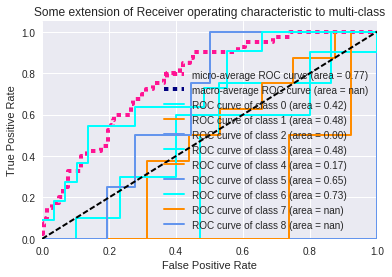

In [55]:
helpers.plot_roc_curve(y_test, test_prob)